In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import constants as c
import scipy.constants as sc
import math
import pandas as pd
import scipy
from scipy import interpolate
import scipy.integrate as integrate
from scipy.interpolate import interp1d
from scipy.interpolate import interpnd
from scipy.integrate import quad
from sympy import Symbol
import sympy as sp
from functools import partial
import sys
import matplotlib.image as img
from scipy.interpolate import griddata

from astropy.modeling import models
from astropy.modeling.models import BlackBody
import astropy.units as u
from dust_extinction.parameter_averages import F99
from ebltable.ebl_from_model import EBL

In [2]:
import devesh_a3p2_directory.a3p2.a3p2.astro.cosmo
from devesh_a3p2_directory.a3p2.a3p2.constants import *
#from devesh_a3p2_directory.a3p2.a3p2.tools.config import ConfigBase
#import devesh_a3p2_directory.a3p2.a3p2.ebl.measurements

In [3]:
#Reading output from SB99 old
spectrumold = pd.read_csv('/Users/deveshchopra/ebl/final run_spectrum.csv', skiprows = 0) # with kroupa imf and initial mass being 100Mo
print(spectrumold.head())
awsold = spectrumold[spectrumold.Time == 2.270600e+06].Wavelength # all wavelengths from SB99
atsold = spectrumold[spectrumold.Wavelength == 91].Time # all time epochs from SB99

        Time  Wavelength  LogTOTAL  LogSTELLA  LogNEBUL
0  2270600.0        91.0  25.60646   25.60646     -15.0
1  2270600.0        94.0  25.62327   25.62327     -15.0
2  2270600.0        96.0  25.63802   25.63802     -15.0
3  2270600.0        98.0  25.65265   25.65265     -15.0
4  2270600.0       100.0  25.67387   25.67387     -15.0


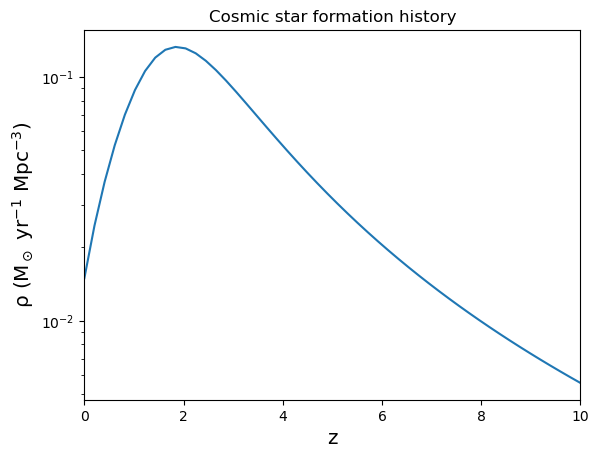

In [4]:
#Updated Starformation rate History(Madau) as a function of redshift
ρo = .015  #Mo/yr/Mpc3

#defining sfrd Mo/yr/Mpc3
def ρ(Z):
    return ρo*(((1+Z)**2.7) /(1+((1+Z)/2.9)**5.6)) #Mo/yr/Mpc3

plt.plot(np.linspace(0,10),[ρ(i) for i in np.linspace(0,10)])
plt.yscale('log')
plt.xlabel('z',size = 'x-large')
plt.ylabel('ρ (M$_\odot$ yr$^{-1}$ Mpc$^{-3}$)',size = 'x-large')
plt.title('Cosmic star formation history')
plt.xlim(0,10)
plt.show()
#plt.savefig('sfrd Madau')

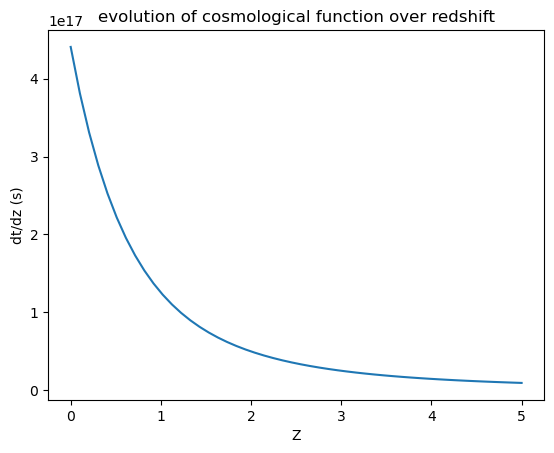

In [5]:
#introducinh Ho
#Writing down equation of state E(Z) to get dt/dz
#h  = 0.5  # would be updated later on
#Ho = h*100   #km/s/Mpc

# using 737 cosmology
Ωr = 0
Ωm = 0.3
ΩΛ = 0.7
Ωk = 0
Ωo = Ωr + Ωm + ΩΛ + Ωk 

def E(Z):
    return np.sqrt(Ωr*(1+Z)**4 + Ωm*(1+Z)**3 + Ωk*(1+Z)**2 + ΩΛ)

#defining dt/dz (the cosmological parameters enters our calculation through here)
def dtbydz(Z,Ho):
    return (1/(Ho*(1+Z)*E(Z)))*3.086*(10**19)  #s


plt.plot(np.linspace(0,5),[dtbydz(Z,70) for Z in np.linspace(0,5)])
plt.xlabel('Z')
plt.ylabel('dt/dz (s)')
plt.title('evolution of cosmological function over redshift')

#time as a function of redshift
def t(Z):
    return (14e9)*((1/(1+Z))**1.5)

#defining t(Z) arXiv:gr-qc/0506079v2
#def t(Z):
#    return 2/(Ho*(1+(1+Z)**2))

In [23]:
#martins code modified
import sys
import time
import logging
import gzip
import pandas as pd

import astropy.io.fits as pyfits
import numpy as np
import scipy.interpolate
import scipy.integrate
import matplotlib.pyplot as plt
import scipy.constants as si
from astropy import constants as c

def read_ssp_sb99(datfile) :
    """
    Read simple stellar population model spectra from starburst 99 output:
    http://www.stsci.edu/science/starburst99/
    
    [erg s^-1 A^-1], 1E6 M_solar
    """
    d = np.loadtxt(datfile, skiprows=6)
    # Get unique time steps
    tt = d[:,0].tolist()
    tt.sort()
    unique = [x for i, x in enumerate(tt) if not i or x != tt[i-1]]
    t = np.asarray(unique)
    # Read spectra, store in data array
    l, dd, first = None, None, True
    for ts in t :
        dt = d[d[:,0] == ts, :]
        if first :
            l = dt[:,1]
            dd = dt[:, 3][:, np.newaxis]
            first = False
        else :
            dd = np.hstack([dd, dt[:, 3][:, np.newaxis]])
    dx = np.log10(si.c / l[::-1] / 1E-10) # log(frequency/Hz)
    dy = np.log10(t) # log(Time/yrs)
    dz = (dd[::-1] - 6. + np.log10(1E10 * si.c) - 2. * dx[:,np.newaxis])# log(em [erg/s/Hz/M_solar])
    # Sanity
    dz[np.invert(np.isfinite(dz))] = -43.
    return (dx, dy, dz, dd)

ssd = read_ssp_sb99('/Users/deveshchopra/downloads/final run (1).spectrum')

erg_J = 1e-7
eV_J = 1.6e-19

#without a3p2
def apply_dust(d, ebv=.1, ebv2=None, ir_fac=1e9, ir_wave_start=5.5) :
    
    dx, dy, dz, dat = d
    # Resample data to encompass larger wavelength range
    logging.info('Extending wavelength range of SSP models for IR emission')
    dat_intp = scipy.interpolate.RectBivariateSpline(x=dx, y=dy, z=dz, kx=1, ky=1)
    dx_old = dx
    ir_lnu_min, ir_lnu_max = 11., 17.
    ir_lnu_nsteps = int((ir_lnu_max - ir_lnu_min) / ((dx_old[-1] - dx_old[0]) / len(dx_old)))
    logging.info('ir_lnu_min={0}, ir_lnu_max={1}, ir_lnu_nsteps={2}'.format(ir_lnu_min, ir_lnu_max, ir_lnu_nsteps))
    dx = np.linspace(ir_lnu_min, ir_lnu_max, ir_lnu_nsteps)
    xx = np.ones([len(dx), len(dy)]) * dx[:, np.newaxis]
    yy = np.ones([len(dx), len(dy)]) * dy[np.newaxis, :]
    dz = dat_intp.ev(xx.flatten(), yy.flatten()).reshape([len(dx), len(dy)])
    m = (dx < dx_old[0]) + (dx > dx_old[-1])
    dz[m] = -43.
    dat_intp = scipy.interpolate.RectBivariateSpline(x=dx, y=dy, z=dz, kx=1, ky=1)
   
    def att_kn2002(l) :
        return -.4 *  .68 * 3.2 * ((1. / l) - .35)
    
   # Calculate dust attenuation
    dz_att = np.copy(dz)
    dx_l = (si.c / (10. ** dx) * 1E6)
    
    if ebv2 :
        logging.info('Using two step dust emission a la KN02: E(B-V)_1 = {0}, E(B-V)_2 = {1}'.format(ebv, ebv2))
        m = dy <= np.log10(3E8)
        #dz_att[:, m] += (ebv * att_fm2007(dx_l))[:, np.newaxis]
        dz_att[:, m] += (ebv * att_kn2002(dx_l))[:, np.newaxis]
        #dz_att[:, m] += (-.4 *  0.68 * ebv * 3.2 * (1. / (si.c / (10. ** dx) * 1E6) - .35))[:, np.newaxis]
        m = dy > np.log10(3E8)
        #dz_att[:, m] += (ebv * att_fm2007(dx_l))[:, np.newaxis]
        dz_att[:, m] += (ebv2 * att_kn2002(dx_l))[:, np.newaxis]
        #dz_att[:, m] += (-.4 *  0.68 * ebv2 * 3.2 * (1. / (si.c / (10. ** dx) * 1E6) - .35))[:, np.newaxis]
    else :
        #dz_att += (ebv * att_fm2007(dx_l))[:, np.newaxis]
        dz_att += (ebv * att_kn2002(dx_l))[:, np.newaxis]
        #dz_att += (-.4 *  0.68 * ebv * 3.2 * (1. / (si.c / (10. ** dx) * 1E6) - .35))[:, np.newaxis]

    m = (dx < np.log10(13.6 * eV_J / si.h)) * (dx > np.log10(si.c / ir_wave_start / 1E-6))
    int1 = scipy.integrate.simps(
        np.transpose(10. ** dz_att[m, :] * (10. ** dx[m])[:, np.newaxis] * np.log(10.)),
        np.transpose(np.ones(dz_att[m, :].shape) * dx[m][:, np.newaxis])
        )
    
    # DEBUG
    # Double UV
    #m =  (dx > np.log10(si.c / ir_wave_start / 1E-6))
    # END DEBUG
    int2 = scipy.integrate.simps(
        np.transpose(10. ** dz[m, :] * (10. ** dx[m])[:, np.newaxis] * np.log(10.)),
        np.transpose(np.ones(dz[m, :].shape) * dx[m][:, np.newaxis])
        )
    int1 *= erg_J / c.L_sun.value
    int2 *= erg_J /c.L_sun.value
    l_dust_att = int2 - int1
    
    #DEBUG
    #l_dust_att[dy < 6.75] *= 2.
    #END DEBUG
    m = dx > np.log10(13.6 * eV_J / si.h)
    l_ion = scipy.integrate.simps(
        np.transpose(10. ** dz[m] * (10. ** dx[m])[:, np.newaxis] * np.log(10.)),
        np.transpose(np.ones(dz[m].shape) * dx[m][:, np.newaxis])
        ) *  erg_J / c.L_sun.value
    f_lya = .68
    ir_fac = 1. / ir_fac
    
    # Read IR SEDs from Chary & Elbaz 2001
    f = pyfits.open('/Users/deveshchopra/ebl/chary_elbaz.fits')
    d = f[1].data
    ir_l = d.field('LAMBDA')[0]
    ir_lnu = np.log10(si.c / ir_l[::-1] / 1E-6)
    ir_lf = np.log10(d.field('NULNUINLSUN')[0])
    x, y = ir_lf.shape
    ir_lf = ir_lf[::-1]  - ir_lnu[:, np.newaxis] + np.log10(ir_fac) + np.log10(c.L_sun.value * 1E7)              
    ir_lint = np.log10(d.field('LIR')[0]) + np.log10(ir_fac)
    # Calculate integrated IR emission from ir_wave_start to 1E3 micrometer
    m = (ir_lnu < np.log10(si.c / ir_wave_start / 1E-6)) * (ir_lnu > np.log10(si.c / 1E3 / 1E-6))
    ir_lint_alt = np.log10(
        scipy.integrate.simps(np.transpose(10. ** (ir_lf[m] - 12.)* (10. ** ir_lnu[m])[:, np.newaxis] * np.log(10.)),
                              np.transpose(np.ones(ir_lf[m].shape) * ir_lnu[m][:, np.newaxis]))
        * erg_J / c.L_sun.value
        ) + 12.

    ir_lint = ir_lint_alt
    ir_intp = scipy.interpolate.RectBivariateSpline(x=ir_lnu, y=ir_lint, z=ir_lf, kx=1, ky=1)

    ir_lnu_cube = np.ones(dz.shape) * dx[:, np.newaxis]
    ir_lint_cube = np.ones(dz.shape) *  np.log10((l_dust_att + l_ion * f_lya)[np.newaxis, :])

    ir_dz = ir_intp.ev(ir_lnu_cube.flatten(), ir_lint_cube.flatten()).reshape(dz.shape)

    # Cut off IR emission at wavelength ir_wave_start
    ir_dz[dx > np.log10(si.c / ir_wave_start / 1E-6)] = -43.

    # rescale IR emission for out of range spectra
    m = ir_lint_cube > ir_lint[-1]
    if np.any(m) :
        logging.info('IR emission: scaling up dust emission for {0} spectra'.format(np.sum(m) / len(dx)))
        ir_dz[m] += (ir_lint_cube[m] - ir_lint[-1])
    m = ir_lint_cube < ir_lint[0]
    if np.any(m) :
        logging.info('IR emission: scaling down dust emission for {0} spectra'.format(np.sum(m) / len(dx)))
        ir_dz[m] += (ir_lint_cube[m] - ir_lint[0])
        
    # Set emission to infrared + attenuated UV-O-NIR emission
    dz = np.log10(10. ** ir_dz + 10. ** dz_att)

    dat_intp = None
    dz_att = None
    ir_l, ir_lnu, ir_lf, d = None, None, None, None
    ir_lint, ir_intp = None, None
    ir_lnu_cube, ir_lint_cube, ir_dz = None, None, None
    f.close()
    
    return (dx, dy, dz, dat)

ad = apply_dust(ssd)

Mwavelength = (c.c.value/(10**ad[0])[::-1])*1e10
Mtime = 10**ad[1]

In [24]:
k1 = 10**np.tile(ad[1],1725)

k2 = []
for x in range(0, 1725):
    k2.append(((np.tile(Mwavelength[x],54))))

k2 = np.concatenate(k2).tolist()

adl = (ad[2] + 2. * ad[0][:,np.newaxis] + 6 - np.log10(1E10 * si.c))[::-1]

ad1 = np.concatenate(adl).tolist()

spectrumnew = pd.DataFrame({'Time':k1,'Wavelength':k2,'LogTOTAL':ad1})

#spectrumnew
awsnew = spectrumnew[spectrumnew.Time == spectrumnew.iat[93149,0]].Wavelength # all wavelengths from SB99
atsnew = spectrumnew[spectrumnew.Wavelength == spectrumnew.iat[0,1]].Time # all time epochs from SB99

In [25]:
#old
#introducing Ho
# selecting data at any wavlenength from SB99 output
def wavelengthold(λ):
    return spectrumold[spectrumold.Wavelength == λ]

#Converting Lλ to Lν
def Lνold(λ):
    return (((10**wavelengthold(λ).LogTOTAL))*(λ**2)/(3*(10**18)))/(10**6)   #erg/Mo

#to include dust attenuation
#defining average extinction curve
def A(λ) :
    E = 0.1  #E(B-V),color index/ color of dust attenuation
    R = 3.2
    return 0.68 * E * R * ((10000 / λ) - 0.35)  #λ in micro meter
def g(λ):
    if λ<1e6/35:
        return (10**(-0.4*A(λ)))
    else:
        return 1

#interpolation only at SB99 wavelengths
def Lνiold(λ):
    return interp1d(atsold, Lνold(λ), bounds_error=False, fill_value="extrapolate")

#Lν at all wavelengths
awsold = np.array(awsold)
Lνawsold = np.array([Lνold(awsold) for awsold in awsold])

#interpolation of Lν for any wavelength
def Lνwiold(λ):
    XX = np.array([λ])
    YY = []
    for i in range(Lνawsold.shape[1]):
        f = scipy.interpolate.UnivariateSpline(awsold, Lνawsold[:, i],s=0,k=1)
        for j in range(len(XX)):
            YY = np.append(YY,f(XX[j]))
    return YY

#interpolation of Lν(Z,λ) as a function of redshifts and wavelengths
def Lνifold(Z,λ):
    intp = scipy.interpolate.UnivariateSpline(atsold,Lνwiold(λ),s=0,k=1)
    return intp

#integrating Lν to get Eν
Zm = 5 #redshift where star formation begins
def Eνold(Z,λ,Ho):
    L = Lνifold(Z,λ)
    def i(Zp,Z,Ho):
        return L((t(Z))-t(Zp))*g(λ)*ρ(Zp)*dtbydz(Zp,Ho)/3.154e7  #with g(λ) = 10**-0.4Aλ
    return integrate.quad(i,Z,Zm,args=(Z,Ho),limit=50)[0]

#Zm = 5 #redshift where star formation begins
#def Eνold(Z,λ,Ho):
#    L = Lνifold(Z,λ)
#    def i(Zp,Z,Ho):
#        return L((t(Z))-t(Zp))*fescdAf(λ*1e-4,Z)*ρ(Zp)*dtbydz(Zp,Ho)/3.154e7  #with g(λ) = 10**-0.4Aλ
#    return integrate.quad(i,Z,Zm,args=(Z,Ho),limit=50)[0]

In [26]:
#wavelength in microns
def Az(Z):
    md = 1.52
    nd = 0.35
    pd = 4.12
    qd = 5.89
    return md*((1+Z)**nd)/(1+(((1+Z)/pd)**qd))

#model A parameters of finke
[fesc1,fesc2,fesc3,fesc4,fesc5,l1,l2,l3,l4,l5] = [1.88,2.18,2.93,3.93,8.57,0.15,0.167,0.218,0.422,2.0] #microns

def fescdA(λ):
    if λ <= l2:
        return fesc2 + (fesc2 - fesc1)/(np.log10(l2) - np.log10(l1))*(np.log10(λ) - np.log10(l2))
    if l2 < λ <= l3:
        return fesc3 + (fesc3 - fesc2)/(np.log10(l3) - np.log10(l2))*(np.log10(λ) - np.log10(l3))
    if l3 < λ <= l4:
        return fesc4 + (fesc4 - fesc3)/(np.log10(l4) - np.log10(l3))*(np.log10(λ) - np.log10(l4))       
    if l4 < λ:
        return fesc5 + (fesc5 - fesc4)/(np.log10(l5) - np.log10(l4))*(np.log10(λ) - np.log10(l5))
    
def fescdAf(λ,Z):
        k = (fescdA(λ)/fescdA(0.1500))*(10**(-0.4*Az(Z)))
        if k<=1:
            return k
        else:
            return 1

In [27]:
#new
#modifing to get ir emission
#introducing Ho
# selecting data at any wavlenength from SB99 output
def wavelengthnew(λ):
    return spectrumnew[spectrumnew.Wavelength == λ]

#Converting Lλ to Lν
def Lνnew(λ):
    return (((10**wavelengthnew(λ).LogTOTAL))*(λ**2)/(3*(10**18)))/(10**6)   #erg/Mo

#interpolation only at SB99 wavelengths
def Lνinew(λ):
    return interp1d(atsnew, Lνnew(λ), bounds_error=False, fill_value="extrapolate")

#Lν at all wavelengths
awsnew = np.array(awsnew)
Lνawsnew = np.array([Lνnew(awsnew) for awsnew in awsnew])

#interpolation of Lν for any wavelength
def Lνwinew(λ):
    XX = np.array([λ])
    YY = []
    for i in range(Lνawsnew.shape[1]):
        f = scipy.interpolate.UnivariateSpline(awsnew, Lνawsnew[:, i],s=0,k=1)
        for j in range(len(XX)):
            YY = np.append(YY,f(XX[j]))
    return YY

#interpolation of Lν(Z,λ) as a function of redshifts and wavelengths
def Lνifnew(Z,λ):
    intp = scipy.interpolate.UnivariateSpline(atsnew,Lνwinew(λ),s=0,k=1)
    return intp

#integrating Lν to get Eν
Zm = 5 #redshift where star formation begins
def Eνnew(Z,λ,Ho):
    L = Lνifnew(Z,λ)
    def i(Zp,Z,Ho):
        return L((t(Z))-t(Zp))*ρ(Zp)*dtbydz(Zp,Ho)/3.154e7  #with g(λ) = 10**-0.4Aλ
    return integrate.quad(i,Z,Zm,args=(Z,Ho),limit=50)[0]

In [28]:
#old
#defining integrand for νIν calculation
def Izold(Zp,Z,λ,Ho):
    return Eνold(Zp,λ*((1+Z)/(1+Zp)),Ho)*dtbydz(Zp,Ho)

#using simpsons integration to get νIν
def sfsold(Z,λ,Ho):
    return [Izold(Zp,Z,λ,Ho) for Zp in np.linspace(Z,Zm)]
def siold(Z,λ,Ho):
    return np.array(3/(4*np.pi*λ*1e39))*integrate.simpson(sfsold(Z,λ,Ho),np.linspace(Z,Zm))

In [29]:
#new
#defining integrand for νIν calculation
def Iznew(Zp,Z,λ,Ho):
    return Eνnew(Zp,λ*((1+Z)/(1+Zp)),Ho)*dtbydz(Zp,Ho)

#using simpsons integration to get νIν
def sfsnew(Z,λ,Ho):
    return [Iznew(Zp,Z,λ,Ho) for Zp in np.linspace(Z,Zm)]
def sinew(Z,λ,Ho):
    return np.array(3/(4*np.pi*λ*1e39))*integrate.simpson(sfsnew(Z,λ,Ho),np.linspace(Z,Zm))

#using quad for integration to get νIν
#def Pνlz(Z,λ):
#    return np.array(3/(4*np.pi*λ*1e39))*integrate.quad(Iz,Z,Zm,args=(Z,λ),limit=50)[0]

In [13]:
#calculate the ebl over complete range
ebl737z0old = [siold(0,λ,70) for λ in np.logspace(np.log10(1e3),np.log10(1e6/35))]
ebl737z0new = [sinew(0,λ,70) for λ in np.logspace(np.log10(1e6/35),np.log10(1e7))]
eblf = np.concatenate([ebl737z0old,ebl737z0new])
npf = np.concatenate([np.logspace(np.log10(1e3),np.log10(1e6/35)),np.logspace(np.log10(1e6/35),np.log10(1e7))])

/var/folders/q1/lnzb6xf54vb5pw52pxtbc39c0000gn/T/ipykernel_8636/3254521654.py:52: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(i,Z,Zm,args=(Z,Ho),limit=50)[0]
/var/folders/q1/lnzb6xf54vb5pw52pxtbc39c0000gn/T/ipykernel_8636/3254521654.py:52: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(i,Z,Zm,args=(Z,Ho),limit=50)[0]
/v

In [22]:
ebl737z0oldebv02 = [siold(0,λ,70) for λ in np.logspace(np.log10(1e3),np.log10(1e6/35))]
ebl737z0newebv02 = [sinew(0,λ,70) for λ in np.logspace(np.log10(1e6/35),np.log10(1e7))]
eblfebv02 = np.concatenate([ebl737z0oldebv02,ebl737z0newebv02])

/var/folders/q1/lnzb6xf54vb5pw52pxtbc39c0000gn/T/ipykernel_8636/1003944273.py:52: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(i,Z,Zm,args=(Z,Ho),limit=50)[0]
/var/folders/q1/lnzb6xf54vb5pw52pxtbc39c0000gn/T/ipykernel_8636/1003944273.py:52: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(i,Z,Zm,args=(Z,Ho),limit=50)[0]
/v

In [30]:
ebl737z0oldebv01 = [siold(0,λ,70) for λ in np.logspace(np.log10(1e3),np.log10(1e6/35))]
ebl737z0newebv01 = [sinew(0,λ,70) for λ in np.logspace(np.log10(1e6/35),np.log10(1e7))]
eblfebv01 = np.concatenate([ebl737z0oldebv01,ebl737z0newebv01])

/var/folders/q1/lnzb6xf54vb5pw52pxtbc39c0000gn/T/ipykernel_8636/1030987789.py:52: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(i,Z,Zm,args=(Z,Ho),limit=50)[0]
/var/folders/q1/lnzb6xf54vb5pw52pxtbc39c0000gn/T/ipykernel_8636/1030987789.py:52: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(i,Z,Zm,args=(Z,Ho),limit=50)[0]
/v

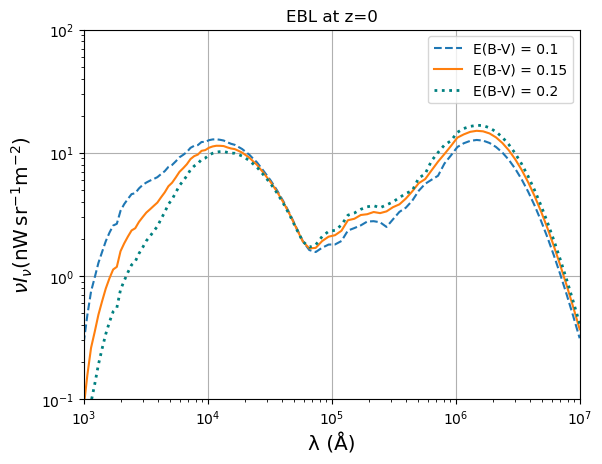

In [32]:
plt.plot(npf,eblfebv01,ls=('dashed'),label='E(B-V) = 0.1')
plt.plot(npf,eblf,label='E(B-V) = 0.15')
plt.plot(npf,eblfebv02,ls=('dotted'),label='E(B-V) = 0.2',lw=2,color='teal')

#plotting error bars
#plt.errorbar(xNH,yNH,yerr=errorsNH, fmt = 'o',label="New Horizon COB",solid_capstyle='projecting', capsize=5) 
#plt.errorbar(dl*1e4, debl, yerr=debl_err, fmt='o', color='red',capsize=3,label='Driver et al. (2016)')
#plt.errorbar(bwl*1e4, bwebl, xerr=bwl_errx, yerr=bwebl_erry, fmt='o', color='black',capsize=3,label='Biteau & Williams (2015)')

plt.xscale('log')
plt.xlim(1e3,1e7)
plt.ylim(0.1,100)
plt.yscale('log')
plt.xlabel('λ (Å)',size = 'x-large')
#plt.ylabel('νIν(nW/m2/sr)')
plt.ylabel(r'$\nu I_\nu (\mathrm{nW}\,\mathrm{sr}^{-1}\mathrm{m}^{-2})$',size = 'x-large')
plt.legend()
plt.title('EBL at z=0')
plt.grid()
plt.savefig('EBL final')

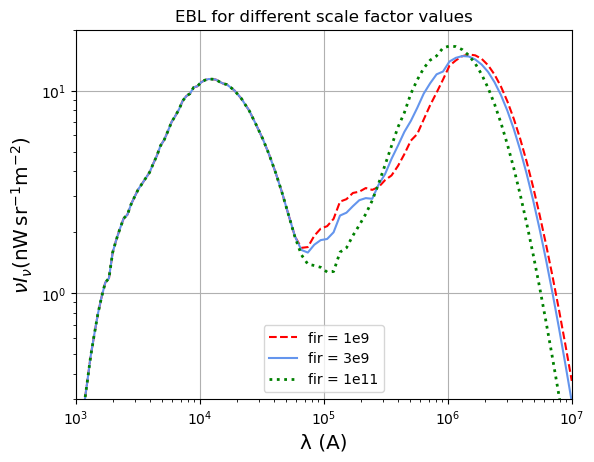

In [43]:
plt.plot(npf,eblffir1e9,ls=('dashed'),label='fir = 1e9',color='r')
plt.plot(npf,eblf,label='fir = 3e9',color='cornflowerblue')
plt.plot(npf,eblffir1e11,ls=('dotted'),label='fir = 1e11',lw=2,color='g')

plt.xscale('log')
plt.xlim(1e3,1e7)
plt.ylim(0.3,20)
plt.yscale('log')
plt.xlabel('λ (A)',size='x-large')
#plt.ylabel('νIν(nW/m2/sr)')
plt.ylabel(r'$\nu I_\nu (\mathrm{nW}\,\mathrm{sr}^{-1}\mathrm{m}^{-2})$',size = 'x-large')
plt.title('Z=0')
plt.legend()
plt.title('EBL for different scale factor values')
plt.grid()
plt.savefig('EBL final')

In [28]:
npf = np.concatenate([np.logspace(np.log10(1e3),np.log10(1e6/35)),np.logspace(np.log10(1e6/34),np.log10(1e7))])
lmu = npf/1e4 #wavelength in microns

#at Z = 0
ebl737z0old = [siold(0,λ,70) for λ in np.logspace(np.log10(1e3),np.log10(1e6/35))]
ebl737z0new = [sinew(0,λ,70) for λ in np.logspace(np.log10(1e6/34),np.log10(1e7))]
IZ0h_70 = np.concatenate([ebl737z0old,ebl737z0new])

#at Z = 0.1
ebl737z01old = [siold(0.1,λ,70) for λ in np.logspace(np.log10(1e3),np.log10(1e6/35))]
ebl737z01new = [sinew(0.1,λ,70) for λ in np.logspace(np.log10(1e6/34),np.log10(1e7))]
IZ01h_70 = np.concatenate([ebl737z01old,ebl737z01new])

#at Z = 1
ebl737z1old = [siold(1,λ,70) for λ in np.logspace(np.log10(1e3),np.log10(1e6/35))]
ebl737z1new = [sinew(1,λ,70) for λ in np.logspace(np.log10(1e6/34),np.log10(1e7))]
IZ1h_70 = np.concatenate([ebl737z1old,ebl737z1new])

/var/folders/q1/lnzb6xf54vb5pw52pxtbc39c0000gn/T/ipykernel_39002/3254521654.py:52: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(i,Z,Zm,args=(Z,Ho),limit=50)[0]
/var/folders/q1/lnzb6xf54vb5pw52pxtbc39c0000gn/T/ipykernel_39002/3254521654.py:52: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(i,Z,Zm,args=(Z,Ho),limit=50)[0]


In [29]:
# making ebl tables in required format
#ho_70
df_h70 = pd.DataFrame()
df_h70[99] = np.append(0.0,lmu)
df_h70[0.0] = np.append(0.0,IZ0h_70)
df_h70[0.1] = np.append(0.1,IZ01h_70)
df_h70[1.0] = np.append(1.0,IZ1h_70)
dfh70 = np.array(df_h70)

#saving the ebl data
np.savetxt('ebl@Ho_70.out',dfh70,'%s')

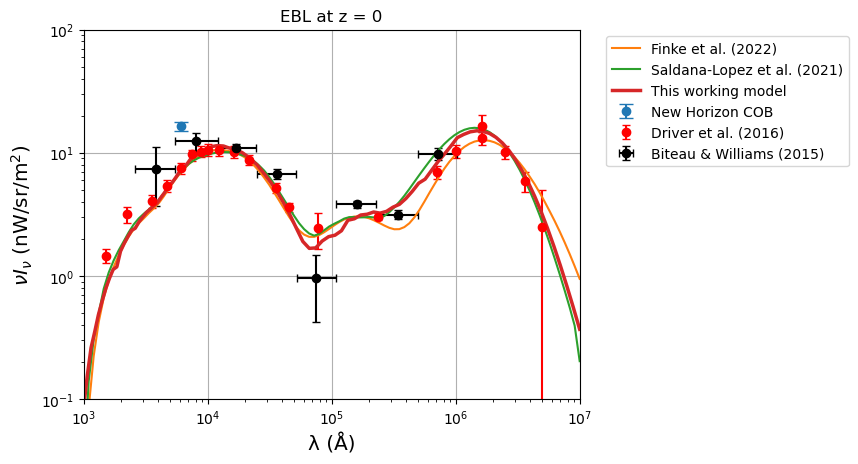

In [31]:
#plotting martin raue ebl data
eblmrz0 = pd.read_csv('/Users/deveshchopra/Downloads/mrebl.csv', skiprows=0)
eblmrwav = eblmrz0.iloc[:,0]
eblmrnuInu = eblmrz0.iloc[:,1]

xNH= 0.608316410892*1e4
yNH = 16.35011377
yerror_upperNH = 17.8004667445-yNH
yerror_lowerNH = yNH - 14.9124854142
errorsNH =[ [yerror_lowerNH],[yerror_upperNH]]
plt.errorbar(xNH,yNH,yerr=errorsNH, fmt = 'o',label="New Horizon COB",solid_capstyle='projecting', capsize=5) 

plt.errorbar(dl*1e4, debl, yerr=debl_err, fmt='o', color='red',capsize=3,label='Driver et al. (2016)')
plt.errorbar(bwl*1e4, bwebl, xerr=bwl_errx, yerr=bwebl_erry, fmt='o', color='black',capsize=3,label='Biteau & Williams (2015)')

plt.loglog(lmu*1e4,nuInufin,label='Finke et al. (2022)')
#plt.loglog(eblmrwav*1e4,eblmrnuInu,label='Martin14')
#plt.loglog(lmu*1e4,nuInukni,label='kni10')
plt.loglog(lmu*1e4,nuInusl,label='Saldana-Lopez et al. (2021)')

plt.loglog(npf,eblf,label='This working model', lw=2.5)

plt.xlim(1e3,1e7)
plt.ylim(0.1,100)
plt.gca().set_xlabel('λ (Å)',size = 'x-large')
plt.gca().set_ylabel(r'$\nu I_\nu $ (nW/sr/m$^2$)',size = 'x-large')
plt.title('Z=0')
#plt.legend(['my result','from the paper'])
plt.title('EBL at z = 0')
plt.grid()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.legend(ncol=1)
#plt.savefig('EBL compared')

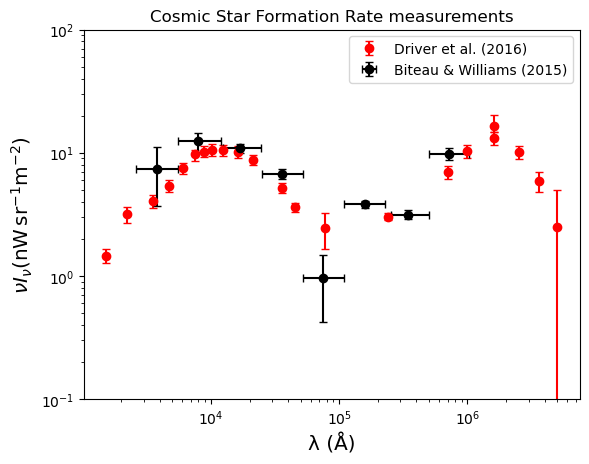

In [21]:
# Data from driver et al. 2016

debld = pd.read_csv('/Users/deveshchopra/Downloads/ebl driver et al. 2016.csv',header=None)
dl = debld.iloc[:,0]
debl = debld.iloc[:,1]

deblue = pd.read_csv('/Users/deveshchopra/Downloads/ebl driver et al. 2016 upper error.csv',header=None)
deblle = pd.read_csv('/Users/deveshchopra/Downloads/ebl driver et al. 2016 lower error.csv',header=None)
deblle.loc[21,1]=0.0004

deblemin = debl - deblle.iloc[:,1]
deblemax = deblue.iloc[:,1] - debl

debl_err = [deblemin,deblemax]

#Rodighiero
#/Users/deveshchopra/Downloads/ebl bw 2015.csv
bwebld = pd.read_csv('/Users/deveshchopra/Downloads/ebl bw 2015.csv',header=None)
bwl = bwebld.iloc[:,0]
bwebl = bwebld.iloc[:,1]

bweblue = pd.read_csv('/Users/deveshchopra/Downloads/ebl bw 2015 upper error.csv',header=None)
bweblle= pd.read_csv('/Users/deveshchopra/Downloads/ebl bw 2015 lower error.csv',header=None)

bwlre = pd.read_csv('/Users/deveshchopra/Downloads/ebl bw 2015 right error.csv',header=None)
bwllfe= pd.read_csv('/Users/deveshchopra/Downloads/ebl bw 2015 left error.csv',header=None)

bwebleminy = bwebl - bweblle.iloc[:,1]
bweblemaxy = bweblue.iloc[:,1] - bwebl

bwebl_erry = [bwebleminy,bweblemaxy]

bwleminx = 1e4*bwl - 1e4*bwllfe.iloc[:,0]
bwlemaxx = 1e4*bwlre.iloc[:,0] - 1e4*bwl

bwl_errx = [bwleminx,bwlemaxx]

# Plotting the data
plt.errorbar(dl*1e4, debl, yerr=debl_err, fmt='o', color='red',capsize=3,label='Driver et al. (2016)')
plt.errorbar(bwl*1e4, bwebl, xerr=bwl_errx, yerr=bwebl_erry, fmt='o', color='black',capsize=3,label='Biteau & Williams (2015)')
plt.xlabel('λ (Å)',size = 'x-large')
plt.ylabel(r'$\nu I_\nu (\mathrm{nW}\,\mathrm{sr}^{-1}\mathrm{m}^{-2})$',size = 'x-large')
plt.title('Cosmic Star Formation Rate measurements')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.1,100)
plt.legend()
plt.show()


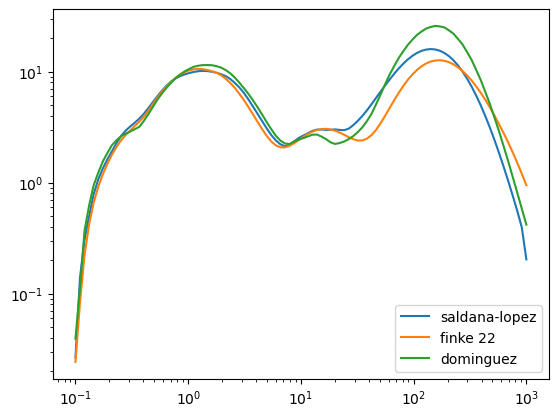

In [19]:
lmu = np.logspace(-1,3.,100)

eblsl = EBL.readmodel('saldana-lopez')
nuInusl = eblsl.ebl_array(0,lmu)

eblfin = EBL.readmodel('finke2022')
nuInufin = eblfin.ebl_array(0,lmu)

ebldom = EBL.readmodel('dominguez')
nuInudom = ebldom.ebl_array(0,lmu)

plt.loglog(lmu,nuInusl,label='saldana-lopez')
plt.loglog(lmu,nuInufin,label='finke 22')
plt.loglog(lmu,nuInudom,label='dominguez')

plt.legend()

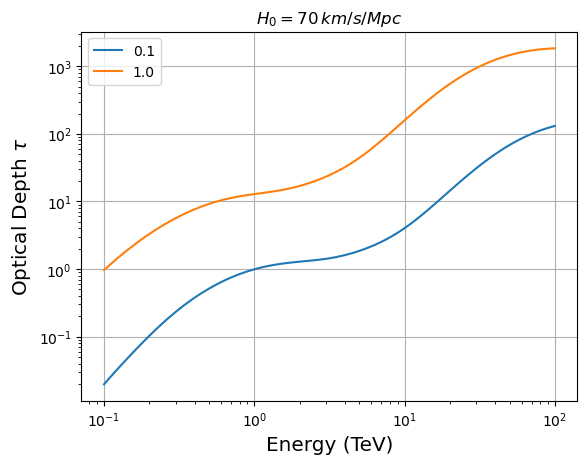

In [32]:
#optical depth calculation
ebl =  EBL.readascii("/Users/deveshchopra/ebl/ebl@Ho_70.out")
ebl._model = "my_model"

h0 = 70.
ETeV = np.logspace(-1,2,100)

z = np.arange(0.,1.2,0.2)
lmu = np.logspace(-1,3.,100)
nuInu = ebl.ebl_array(z,lmu)

zz = [0.1,1.]
for z0 in zz:
    tau = ebl.optical_depth(z0,ETeV,H0 = h0)
    plt.loglog(ETeV, tau, label = z0)
    
plt.legend()
plt.xlabel('Energy (TeV)',size = 'x-large')
plt.ylabel(r'Optical Depth $\tau$',size = 'x-large')
plt.grid()
plt.title(r'$H_0=70\, km/s/Mpc$')
#fig.savefig("output.png", dpi=300)
plt.show()

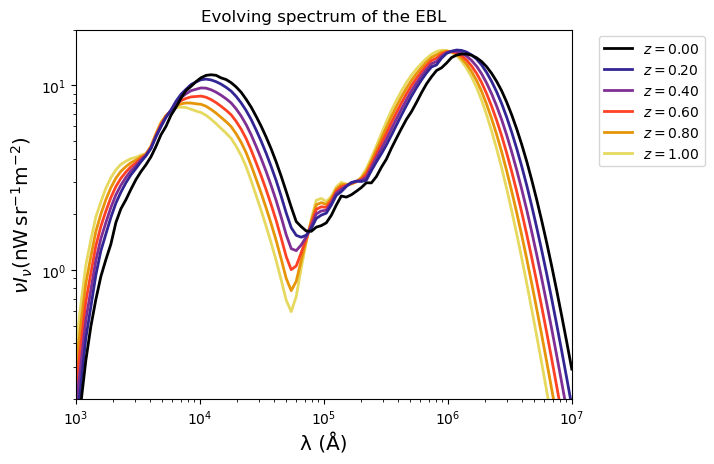

In [55]:
for i,zz in enumerate(z):
    plt.loglog(lmu*1e4,nuInu[i],
              ls = '-', color = plt.cm.CMRmap(i / float(len(z))),
               lw = 2.,
              label = '$z = {0:.2f}$'.format(zz), 
              zorder= -1 * i)
    
plt.gca().set_xlabel('Wavelength ($\mu$m)',size = 'x-large')
plt.xlabel('λ (Å)',size = 'x-large')
plt.gca().set_ylabel(r'$\nu I_\nu (\mathrm{nW}\,\mathrm{sr}^{-1}\mathrm{m}^{-2})$',size = 'x-large')
plt.legend(loc = 'lower center', ncol = 2)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title('Evolving spectrum of the EBL')
plt.xlim(1e3,1e7)
plt.ylim(0.2,20)
plt.savefig('EBL evolution')
plt.show()